In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES']='0'
from IPython.display import display, HTML
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
import keras
from keras.models import *
from keras.layers import *
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)
from keras import backend as K
K.set_session(session)
from exp_smooth import exp_smooth

C:\Users\peter\Anaconda3\envs\tensorflow\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
DATASET_ROOT = './0615'
TRAIN_PATH = os.path.join(DATASET_ROOT, 'taetfp.csv')
AUX_PATH = os.path.join(DATASET_ROOT, 'tasharep.csv')
TS_IN=20
TS_OUT=5
EXP_ALPHA=0.3
fields = ['開盤價(元)', '最高價(元)', '最低價(元)', '收盤價(元)', '成交張數(張)']
fields_dict = dict()
for n, f in enumerate(fields):
    fields_dict[f] = n

In [3]:
train_csv = pd.read_csv(TRAIN_PATH)
train_csv.sort_values(by=['日期', '代碼'], ascending=True, inplace=True)
train_csv[fields] = train_csv[fields].applymap(lambda x: float(x.replace(',','')) if type(x)==str else x)
display(train_csv.head(n=10))

aux_csv = pd.read_csv(AUX_PATH)
aux_csv.sort_values(by=['日期', '代碼'], ascending=True, inplace=True) # 照 '日期' 和 '代碼' 排序 (重要)
aux_csv[fields] = aux_csv[fields].applymap(lambda x: float(x.replace(',','')) if type(x)==str else x)
display(aux_csv.head(n=10))

,代碼,日期,中文簡稱,開盤價(元),最高價(元),最低價(元),收盤價(元),成交張數(張)
0,50,20130102,元大台灣50,46.57,47.13,46.49,46.92,16487.0
1337,51,20130102,元大中型100,22.36,22.66,22.36,22.65,277.0
2674,52,20130102,富邦科技,26.57,26.95,26.57,26.92,26.0
4011,53,20130102,元大電子,19.84,19.84,19.52,19.81,42.0
5348,54,20130102,元大台商50,16.84,16.84,16.54,16.75,20.0
6685,55,20130102,元大MSCI金融,9.85,9.94,9.83,9.91,2210.0
8022,56,20130102,元大高股息,18.45,18.63,18.45,18.55,1623.0
9359,57,20130102,富邦摩台,30.35,30.69,30.35,30.69,69.0
10696,58,20130102,富邦發達,32.45,32.45,32.12,32.12,2.0
12033,59,20130102,富邦金融,24.65,24.65,24.65,24.65,2.0


C:\Users\peter\Anaconda3\envs\tensorflow\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (3,4,5,6) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,代碼,日期,中文簡稱,開盤價(元),最高價(元),最低價(元),收盤價(元),成交張數(張)
0,1101,20130102,台泥,30.41,30.53,30.18,30.45,6374.0
1337,1102,20130102,亞泥,28.74,28.90,28.70,28.78,2856.0
2674,1103,20130102,嘉泥,12.29,12.33,12.24,12.24,315.0
4011,1104,20130102,環泥,11.87,12.17,11.87,12.06,551.0
5348,1108,20130102,幸福,5.18,5.22,5.16,5.18,447.0
6685,1109,20130102,信大,9.24,9.28,9.19,9.24,104.0
8022,1110,20130102,東泥,13.41,13.46,13.23,13.23,169.0
9359,1201,20130102,味全,35.69,37.74,35.44,37.69,8971.0
10696,1203,20130102,味王,16.61,16.78,16.61,16.73,143.0
12033,1210,20130102,大成,16.84,16.99,16.84,16.87,1373.0


In [4]:
codes = list(sorted(set(train_csv['代碼'])))
aux_codes = np.load('codes_subset.npy') # sorted
days  = list(sorted(set(train_csv['日期']))) # 在 taetfp 內出現的日期才被我們使用
#days_dict = dict()
#for n, day in enumerate(days):
#    days_dict[day] = n

In [5]:
aux_csv = aux_csv.loc[aux_csv['代碼'].isin(aux_codes) & aux_csv['日期'].isin(days)] # 只找在 subset 內的資料

In [6]:
split_days = [] # 同一天分一堆
for day in days:
    row = aux_csv.loc[aux_csv['日期']==day][fields]
    split_days.append(np.asarray(row, dtype=np.float32))
split_days = np.asarray(split_days, dtype=np.float32)

In [7]:
print(split_days.shape) # 先當作日期有對齊好 shape: (1317, 1388, 5) -> 1317 天, 每天有 1388 支股票, 每支股票有 5 個 feature

(1337, 1387, 5)


In [8]:
split_days = split_days.reshape(split_days.shape[0], -1) # shape: (1317, 1388*5=6940) , 攤平
print(split_days.shape)

(1337, 6935)


In [9]:
labels = []
for code in codes:
    row   = np.asarray(train_csv.loc[train_csv['代碼']==code][fields], dtype=np.float32)
    label = np.append(np.array([0], dtype=np.uint8), (row[1:,-2] > row[:-1,-2]).astype(np.uint8)).astype(np.uint8)
    labels.append(label)

In [10]:
from sklearn.decomposition import PCA, FastICA
from sklearn.manifold import Isomap, LocallyLinearEmbedding, TSNE, MDS

def plot_embedding(x_emb_,y,n,title=''):
    x_emb = x_emb_[:len(y)]
    ax = plt.subplot()
    for l in range(n):
        idx = (y==l)
        if np.sum(idx)==0:
            print('真可憐' if l==0 else '好棒棒')
            continue
        points = x_emb[idx,:]
        ax.scatter(points[:,0], points[:,1], label=l)
    ax.legend(loc='lower right', frameon=True, prop={'size': 10})
    ax.set_title(title)
    plt.show()

In [11]:
isomap = Isomap(n_neighbors=5, n_components=2, n_jobs=-1)
pca = PCA(n_components=2)
fast_ica = FastICA(n_components=2)
lle = LocallyLinearEmbedding(n_neighbors=5, n_components=2, n_jobs=-1)
mds = MDS(n_components=2, n_jobs=-1)
tsne = TSNE(n_components=2)
%time isomap.fit(split_days)
%time pca.fit(split_days)
%time fast_ica.fit(split_days)
%time lle.fit(split_days)
%time dummy1 = tsne.fit_transform(split_days)
%time dummy2 = mds.fit_transform(split_days)

Wall time: 4.63 s
Wall time: 210 ms
Wall time: 1.45 s
Wall time: 4.33 s
Wall time: 48.9 s


C:\Users\peter\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\pairwise.py:257: RuntimeWarning: invalid value encountered in sqrt
  return distances if squared else np.sqrt(distances, out=distances)


Wall time: 45.1 s


In [12]:
split_days_pca = pca.transform(split_days)
split_days_ica = fast_ica.transform(split_days)
split_days_isomap = isomap.transform(split_days)
split_days_lle = lle.transform(split_days)

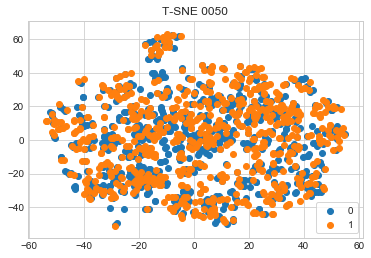

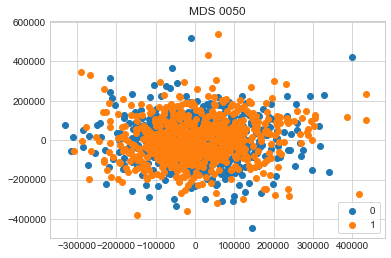

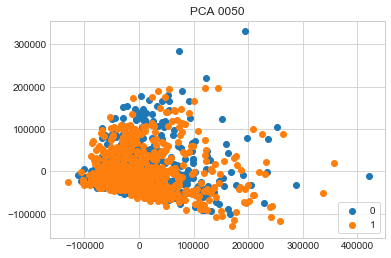

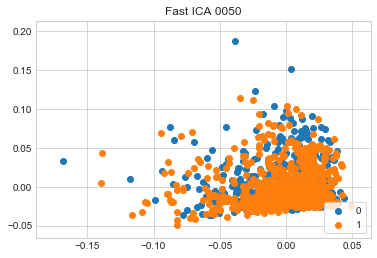

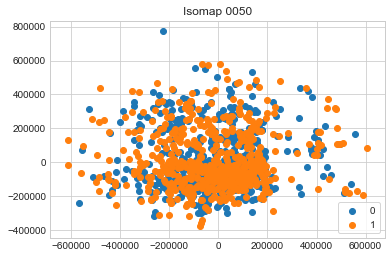

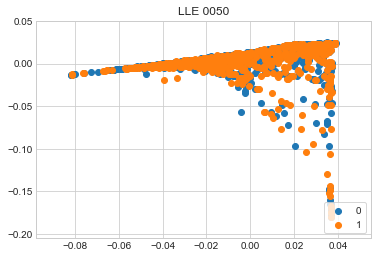

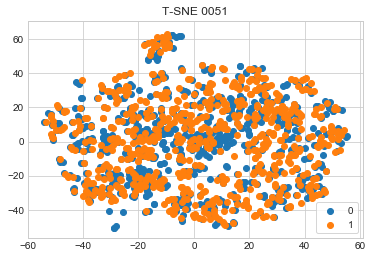

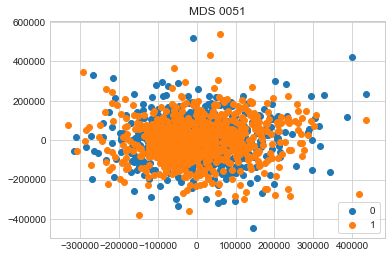

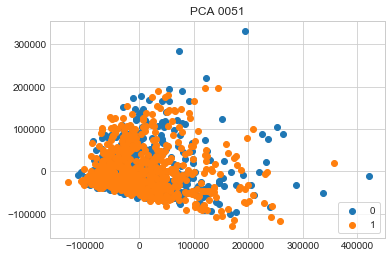

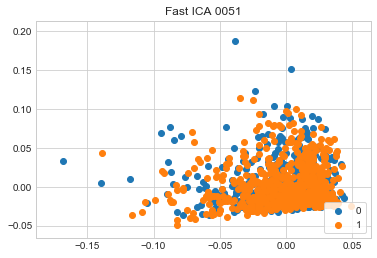

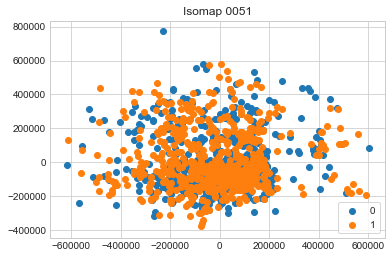

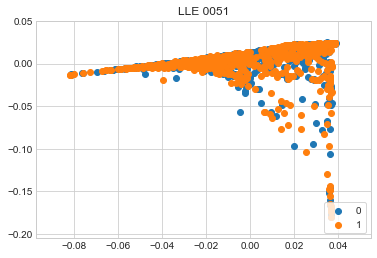

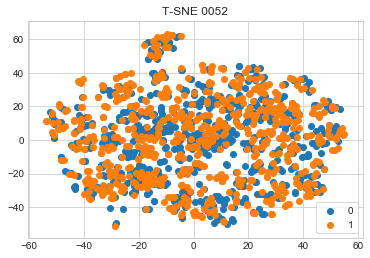

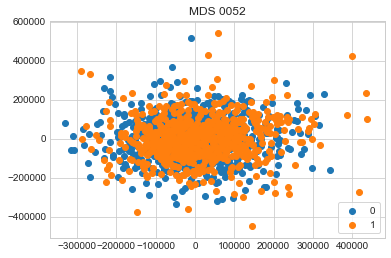

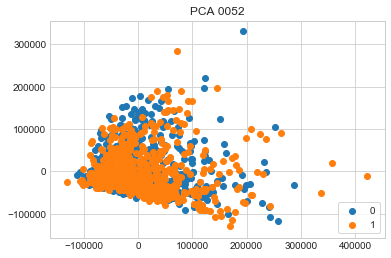

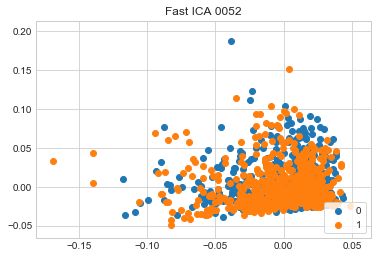

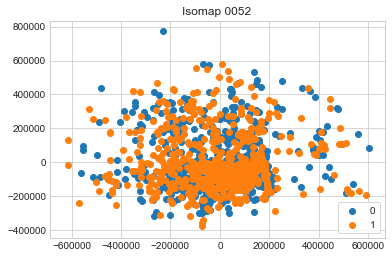

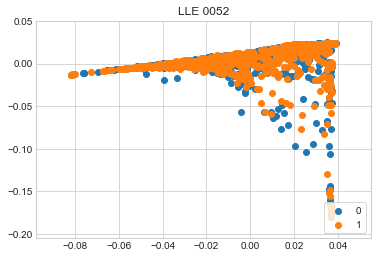

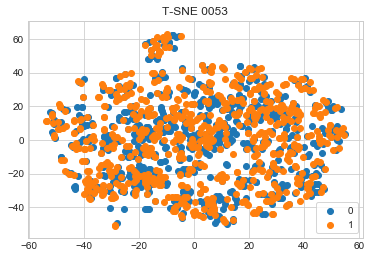

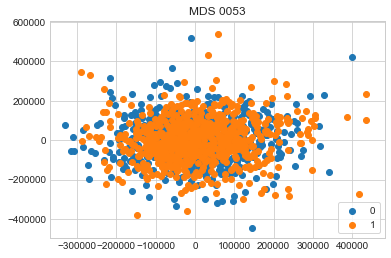

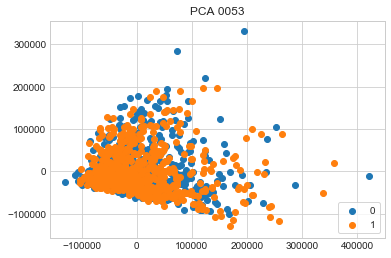

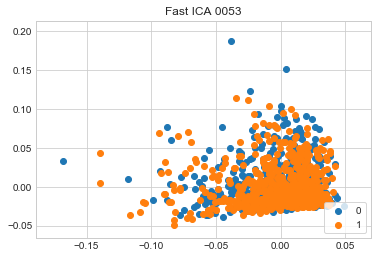

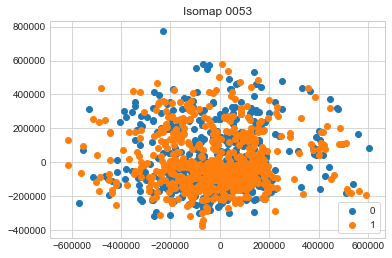

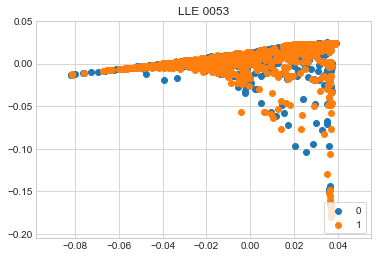

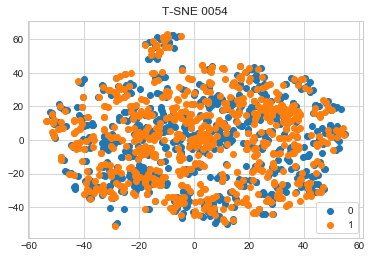

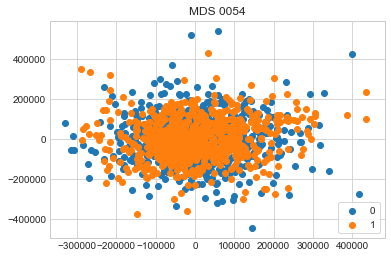

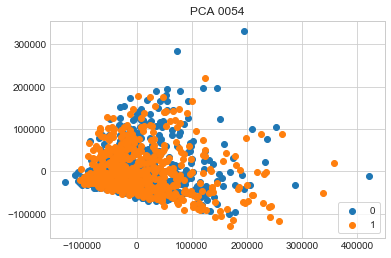

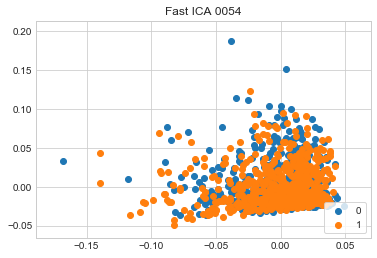

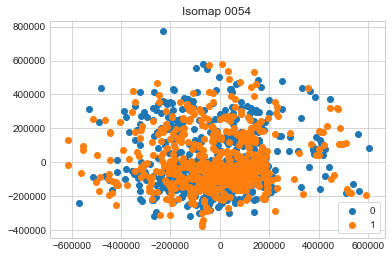

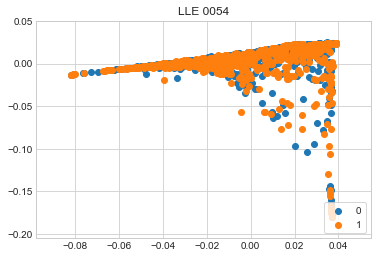

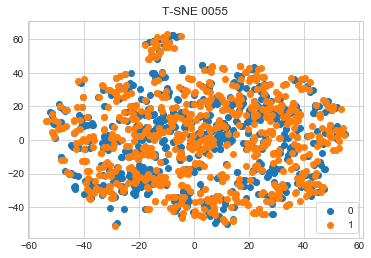

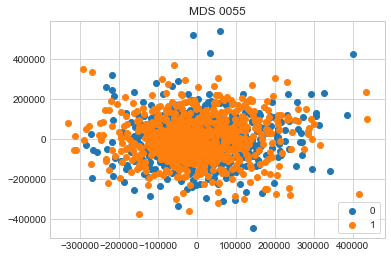

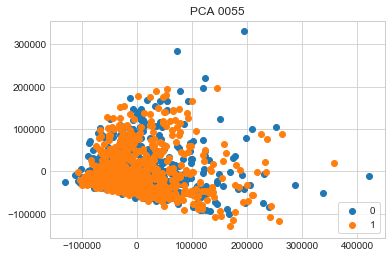

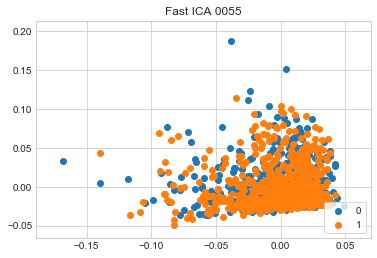

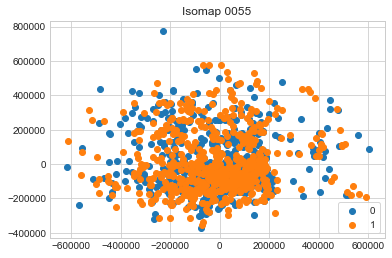

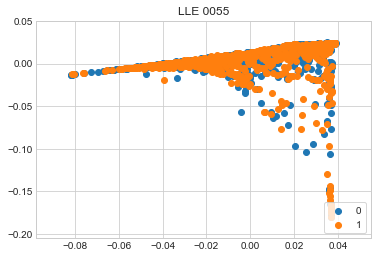

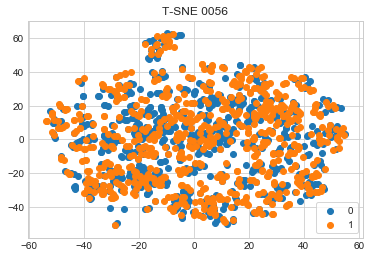

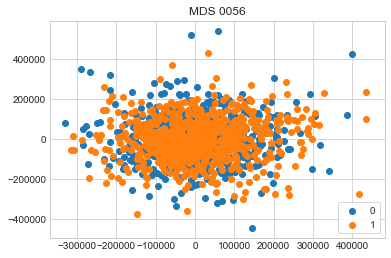

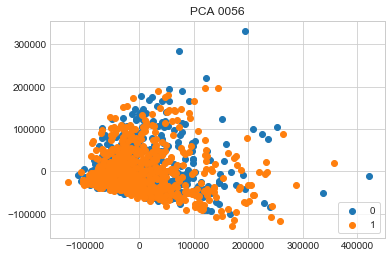

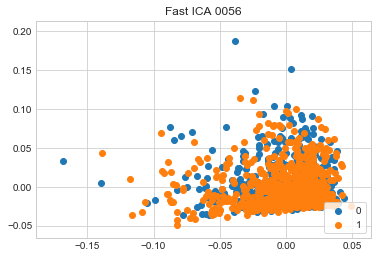

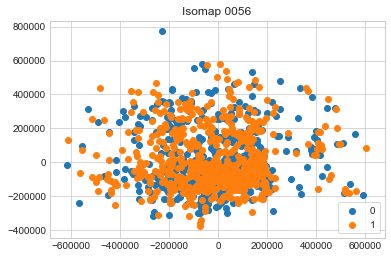

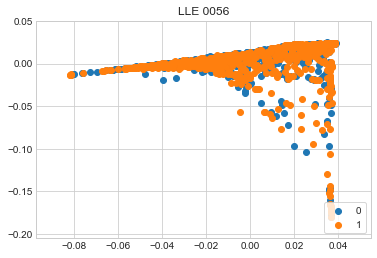

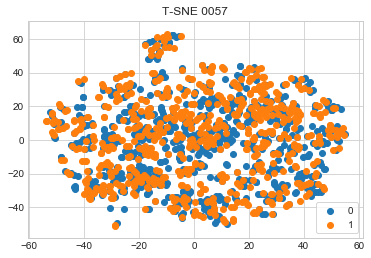

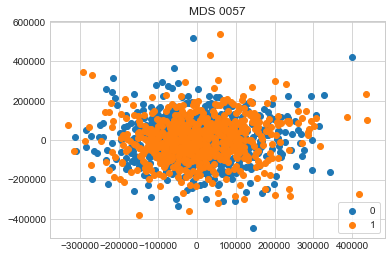

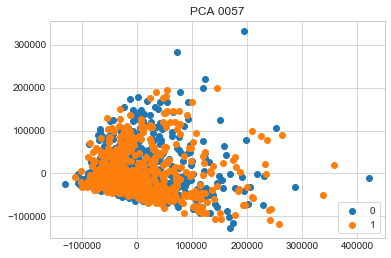

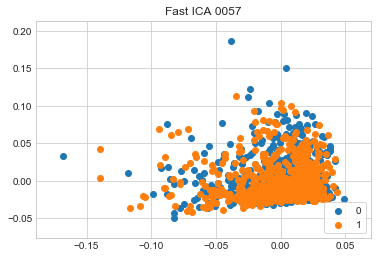

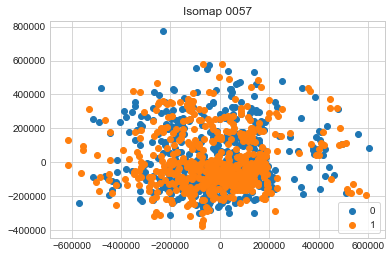

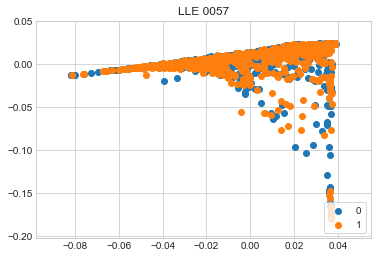

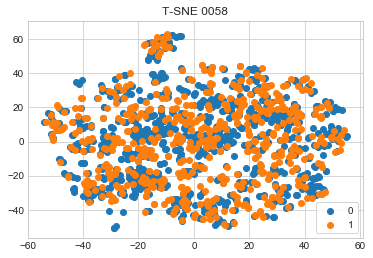

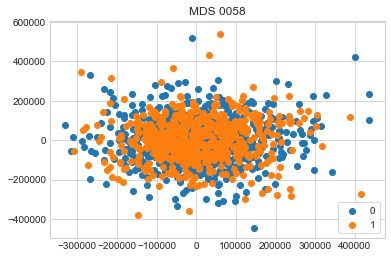

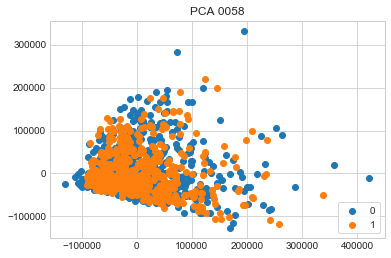

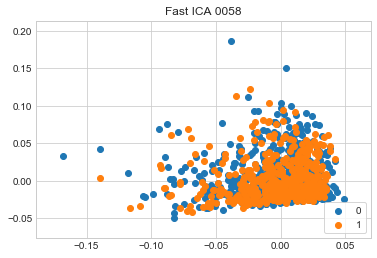

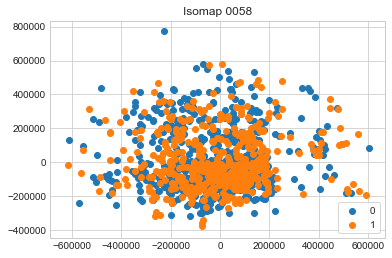

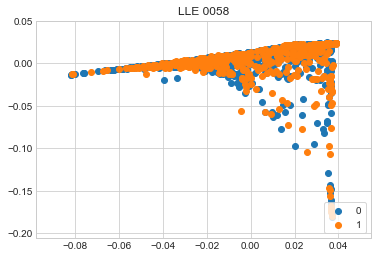

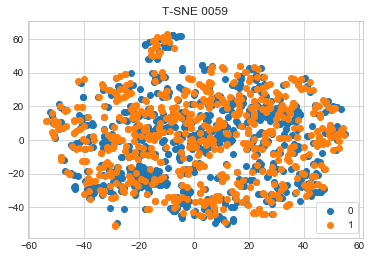

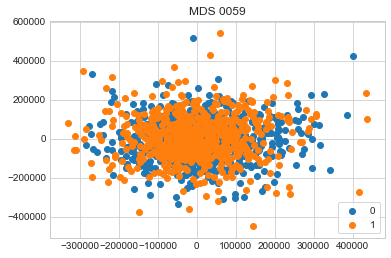

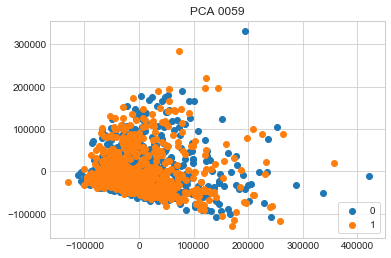

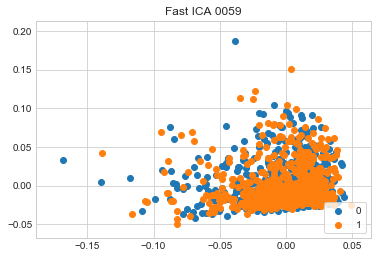

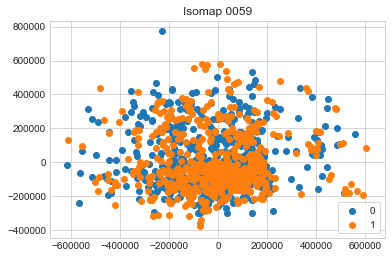

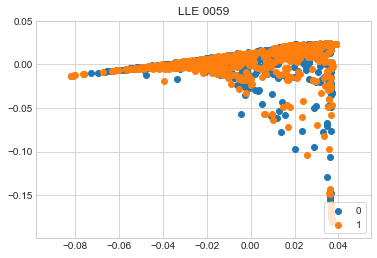

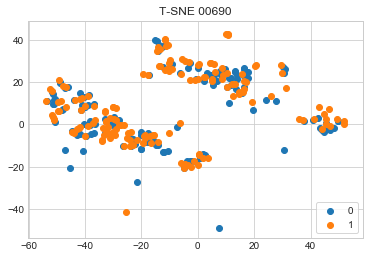

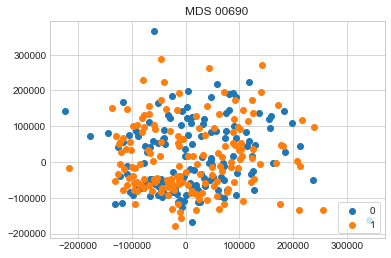

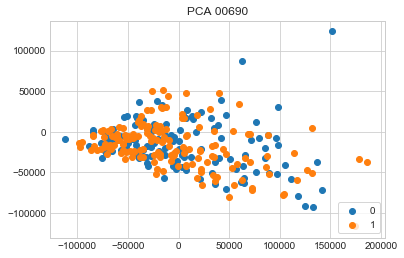

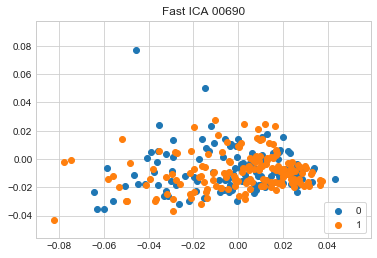

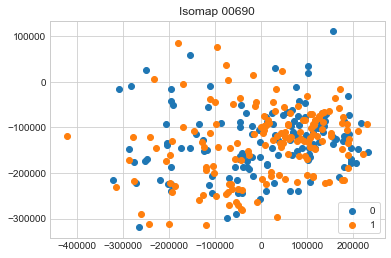

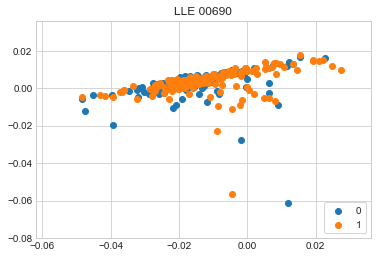

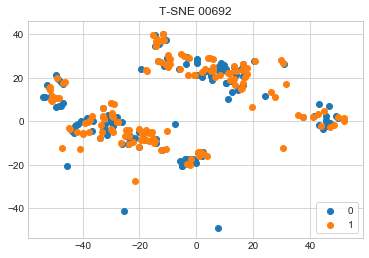

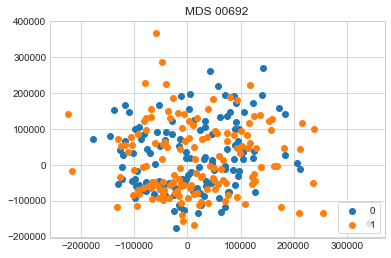

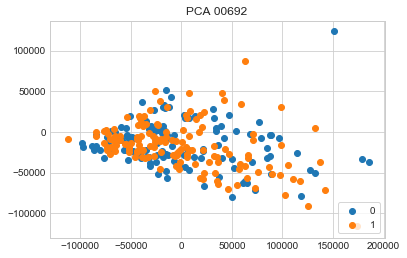

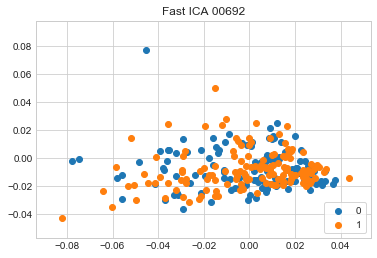

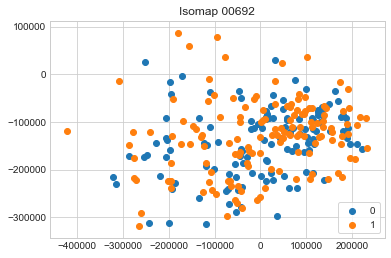

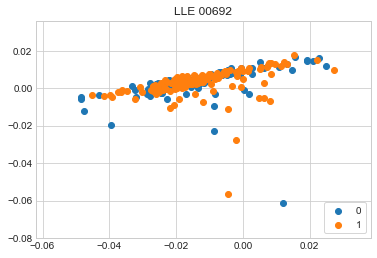

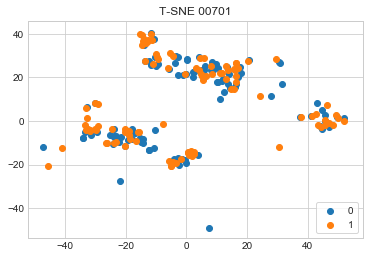

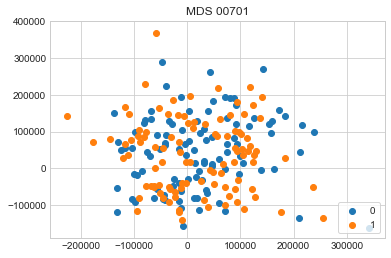

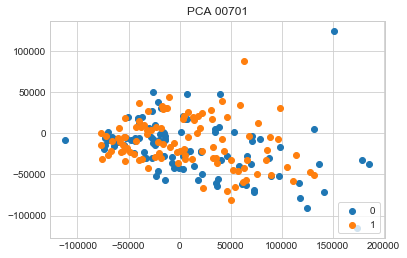

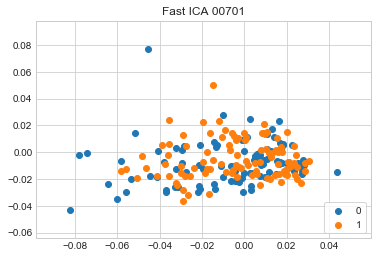

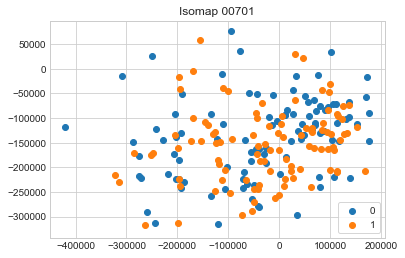

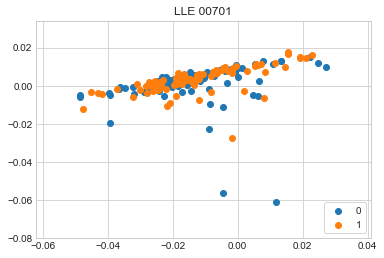

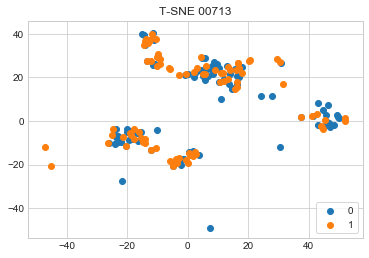

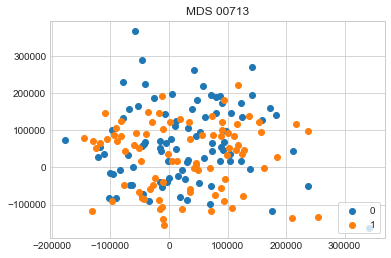

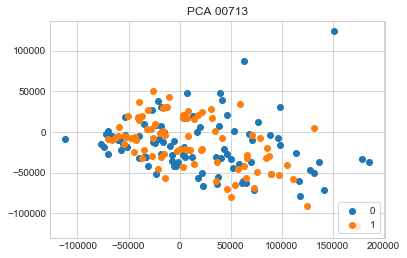

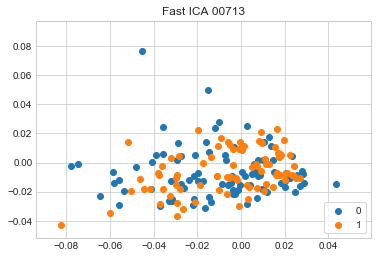

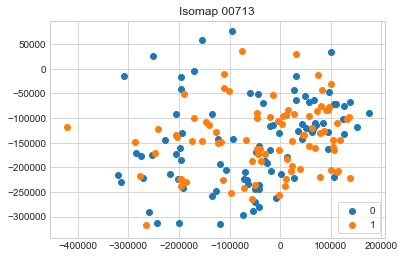

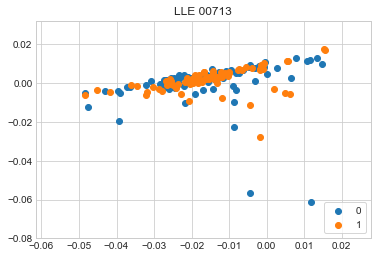

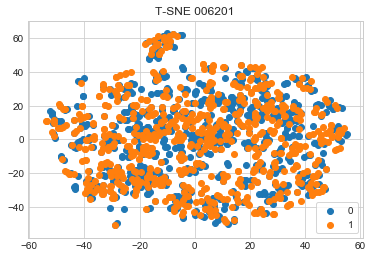

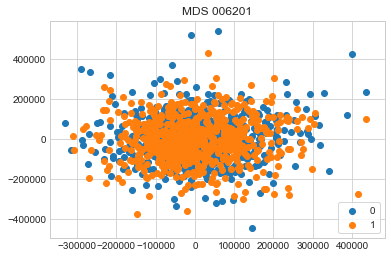

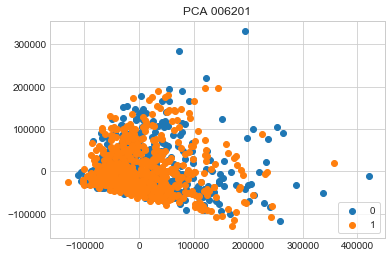

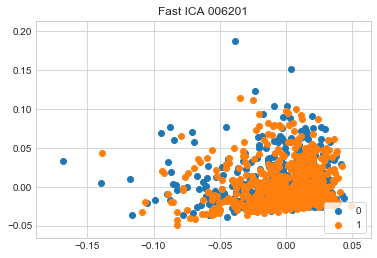

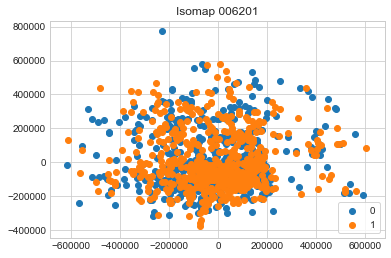

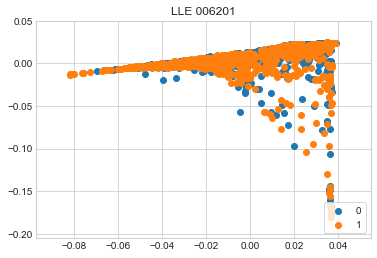

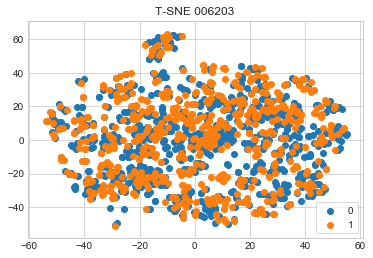

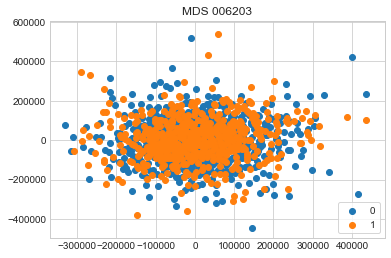

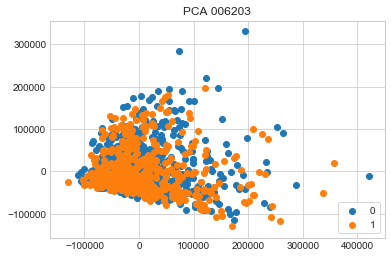

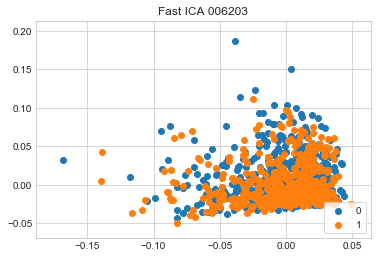

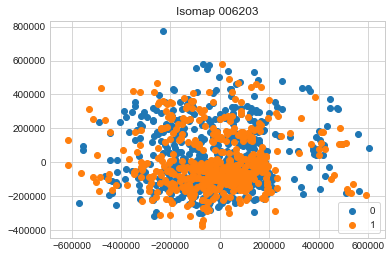

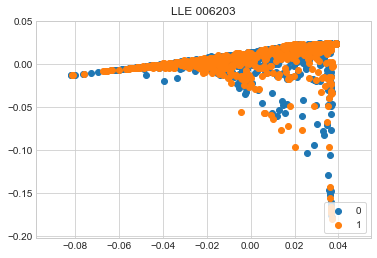

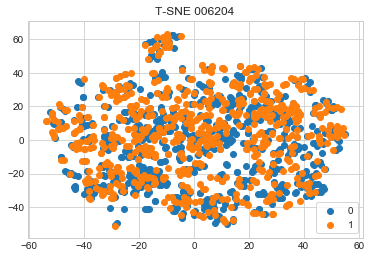

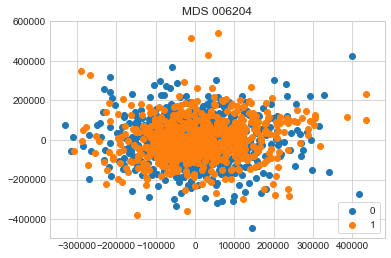

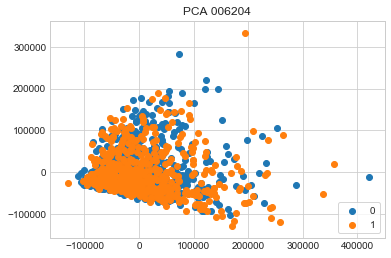

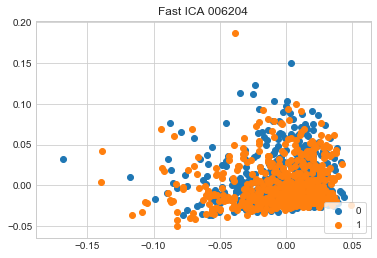

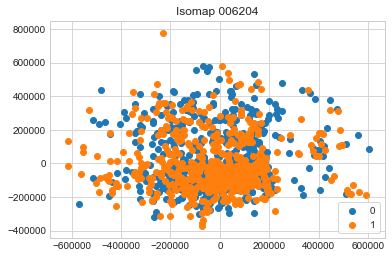

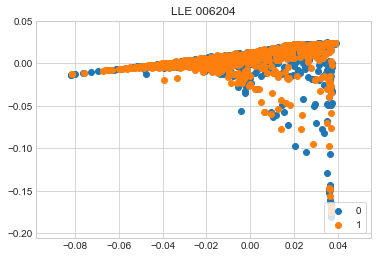

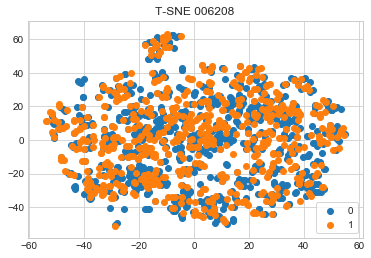

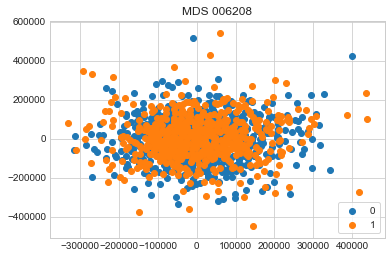

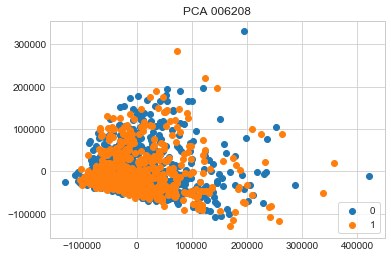

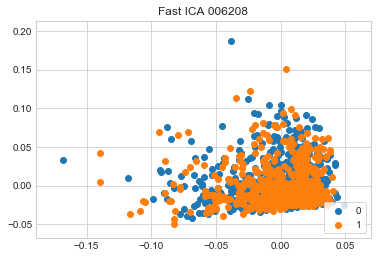

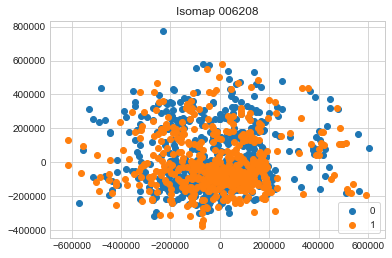

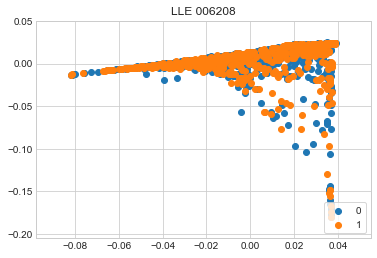

In [13]:
for n, l in enumerate(labels):
    code_str = '00{}'.format(codes[n])
    plot_embedding(dummy1, l, 2, 'T-SNE '+code_str)
    plot_embedding(dummy2, l, 2, 'MDS '+code_str)
    plot_embedding(split_days_pca, l, 2, 'PCA '+code_str)
    plot_embedding(split_days_ica, l, 2, 'Fast ICA '+code_str)
    plot_embedding(split_days_isomap, l, 2, 'Isomap '+code_str)
    plot_embedding(split_days_lle, l, 2, 'LLE '+code_str)

![](https://tbrain.trendmicro.com.tw/Content/img/18etf.png)

#### Todo:
1. Check missing data / value
2. Do more EDA on dataset
3. Try more baseline models (LSTM, GRU, CNN-1D, XGBoost, SVM, ...) 
4. Add Candlestick chart
5. Add n-fold cross validation
6. 是否天數有對齊?
